In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import numbers
from matplotlib.animation import FuncAnimation

# The name of file that contains forcing and observed SWE during every day of water year 2001-2020
forcing_fname = 'EastRiver_hydro_data_2001-2020.csv'

# The name of the file containing parameter combinations and associated KGE values from our
# sensitivity analysis
saved_error_metric_values_fname = 'Snow17_sensitivity_analysis.csv'

date_beg = '2000-10-01' # This is the first day of water year 2016
date_end = '2020-09-30' # This is the last day of water year 2020

DD_i = 5.0 # Initial guess for degree-day factor
Tt_i = 0.0 # Initial guess for temperature threshold

DD_lower = 1.0  # Lower bound for degree-day factor
DD_upper = 10.5 # Upper bound for degree-day factor
Tt_lower = -1.0 # Lower bound for temperature threshold
Tt_upper = 7.0  # Upper bound for temperature threshold


In [30]:
def Snow17(Ta,P,DD,Tt):
    
    assert Ta.shape == P.shape, 'Precipitation and Temperature vectors must have the same shape'
    assert isinstance(DD, numbers.Number), 'Degree day coefficient must be a scalar'
    assert isinstance(Tt, numbers.Number), 'Temperature threshold must be a scalar'

    Nt = np.max(Ta.shape)
    
    SWE_s17 = np.zeros(Ta.shape)
    Sm_s17 = np.zeros(Ta.shape)
    Pliq_s17 = np.zeros(Ta.shape)
    
    for i in np.arange(Nt):

        P_i  = P[i] # The value of precipitation on this date
        Ta_i = Ta[i] # The value of average air temperature on this date

        # Initial conditions: we are starting when there should not be any appreciable snow in the watershed, 
        # so we will assume that SWE = 0. If you decide to run another date when there might be snow (e.g., Jan. 1)
        # then you would need a more realistic value of SWE.
        if(i==0):
            SWE_i = 0.0 
        else:
            SWE_i = SWE_s17[i-1] # The initial SWE on these dates is simply the SWE from the day before. We will add snow or subtract melt.
            
        # If SWE is greater than zero, there *may* be snowmelt
        if(SWE_i>0.0):
            if(Ta_i>Tt): # If the air temperature is greater than the threshold, there **will** be melt
                Sm_i = DD*(Ta_i-Tt) # Snowmelt via degree-day factor
            else: # If the air temperature is below the threshold, there is no melt
                Sm_i = 0.0 # No snowmelt if temperature does not exceed threshold
        else: # If there is no SWE, by definition there is no snowmelt
            Sm_i = 0.0
        
        # If there is precipitation, figure out its phase
        if((P_i>0.0) and (Ta_i<=Tt)):
            SWE_i += P_i # All precip will be added to SWE storage
            Pliq_i = 0.0 # There is no liquid precipitation
        elif((P_i>0.0) and (Ta_i>Tt)):
            Pliq_i = P_i # All precipitation falls as liquid. NOTE: We are assuming rain does not melt snow!!!
        else: # If there is no precipitation, there is nothing to accumulate
            Pliq_i = 0.0
        
        SWE_s17[i] = np.max([SWE_i - Sm_i,0.0]) # Make sure we can only melt as much SWE as there is. This only matters at low SWE
        Sm_s17[i] = Sm_i # Save the snowmelt... QUESTION: Is this something we can observe?!?!?!?!
        Pliq_s17[i] = Pliq_i
        
        
    return SWE_s17, Sm_s17, Pliq_s17

In [31]:
def KlingGuptaEfficiency(y_m,y_o):
    
    # Inputs: 
    # y_m: Modeled time series
    # y_o: Observed time series
    
    # 2. Compute KGE
    # 2a. Get correlation coefficient 
    df_y = pd.DataFrame({'y_m': y_m, 'y_o': y_o})
    rho_mat = df_y.corr().values
    rho = rho_mat[1,0]
    
    # 2b. Get normalized mean 
    beta = np.nanmean(y_m) / np.nanmean(y_o)
     
    # 2c. Get normalized standard deviation
    alpha = np.nanstd(y_m) / np.nanmean(y_o)
    
    # 2d. Compute KGE 
    KGE = 1.0 - np.sqrt((rho - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    
    return KGE

In [32]:
def RMSE(y_m,y_o):
    
    # Inputs: 
    # y_m: Modeled time series
    # y_o: Observed time series
    
    RMSE = np.sqrt(np.nanmean((y_m - y_o)**2))
    
    return RMSE

In [33]:
# Read in the forcing data data
df_forcing = pd.read_csv(forcing_fname)

# Reindex to create make sure that the index for the dataframe is a datetime64 object
df_forcing['Date'] = pd.to_datetime(df_forcing['Date'],format='%Y-%m-%d')
df_forcing.index = df_forcing['Date']

# Here's what a pandas "dataframe" looks like:
df_forcing

,Date,tair,pcp,Q,SWE,PET
Date,,,,,,
2000-10-01,2000-10-01,10.555556,0.00,0.356384,NaN,4.960398
2000-10-02,2000-10-02,10.555556,0.00,0.334212,NaN,4.924742
2000-10-03,2000-10-03,8.333333,0.00,0.332784,NaN,4.243824
2000-10-04,2000-10-04,2.777778,7.62,0.327819,NaN,2.923413
2000-10-05,2000-10-05,4.444444,0.00,0.370463,NaN,3.244371
...,...,...,...,...,...,...
2020-09-26,2020-09-26,12.777778,0.00,0.228555,0.0,5.908478
2020-09-27,2020-09-27,9.444444,0.00,0.230085,0.0,4.757537
2020-09-28,2020-09-28,4.444444,0.00,0.230415,0.0,3.412351


In [34]:
ForcingDates = df_forcing[date_beg:date_end]['Date'].values
P_exp = df_forcing[date_beg:date_end]['pcp'].values
Ta_exp = df_forcing[date_beg:date_end]['tair'].values
SWE_o = df_forcing[date_beg:date_end]['SWE'].values

t = pd.date_range(start=date_beg, end=date_end, freq='1D')

def objective_function_kge(params):
    DD_exp, Tt_exp = params
    
    # 1. Call Snow-17 model 
    SWE_m, Sm_m, Pliq_m = Snow17(Ta_exp,P_exp,DD_exp,Tt_exp)
    
    # 2. Get KGE value for simulated SWE
    KGE_exp = KlingGuptaEfficiency(SWE_m,SWE_o)

    # 3. Return -KGE because the optimization function we're using seeks minimization
    return -KGE_exp
    

In [35]:
intermediate_guesses_list = []

def callback(params):
    intermediate_guesses_list.append(params.copy())

In [36]:
initial_guess = [DD_i, Tt_i]

optimized_params = optimize.minimize(
    objective_function_kge,
    initial_guess, 
    callback=callback, 
    method='CG',
    jac='2-point',
    options={
        'disp': True,
        'maxiter': 1000,
    }
    )

intermediate_guesses = np.array(intermediate_guesses_list)

print("Optimized Parameters:", optimized_params.x)


         Current function value: -0.838914
         Iterations: 7
         Function evaluations: 331
         Gradient evaluations: 110
Optimized Parameters: [1.28558212 0.69071302]


/Users/lejoflores/miniconda3/envs/geos505/lib/python3.11/site-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


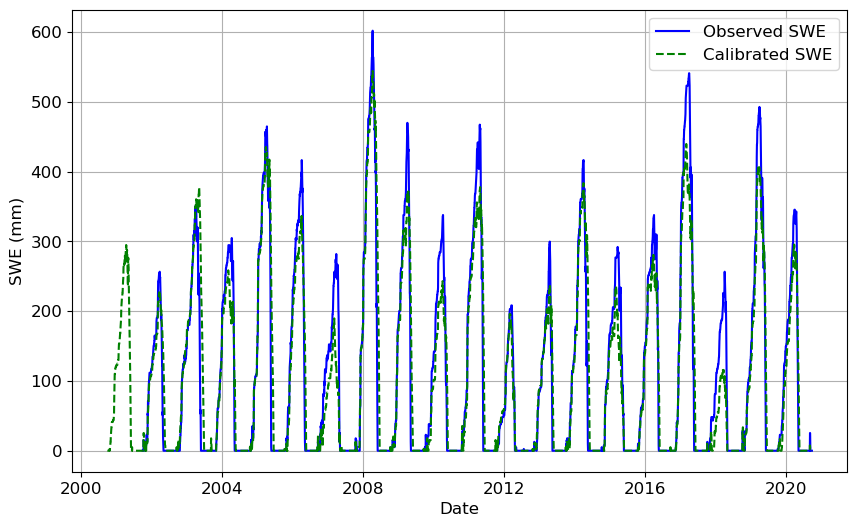

In [37]:
optimized_DD = optimized_params.x[0]
optimized_Tt = optimized_params.x[1]

calibrated_SWE, clibrates_Sm, calibrated_Pliq = Snow17(Ta_exp, P_exp, optimized_DD, optimized_Tt)

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 6))
plt.plot(t, SWE_o, label="Observed SWE", color="blue")
plt.plot(t, calibrated_SWE, label="Calibrated SWE", color="green", linestyle="--")
plt.xlabel("Date")
plt.ylabel("SWE (mm)")
plt.legend()
plt.grid()
plt.show()


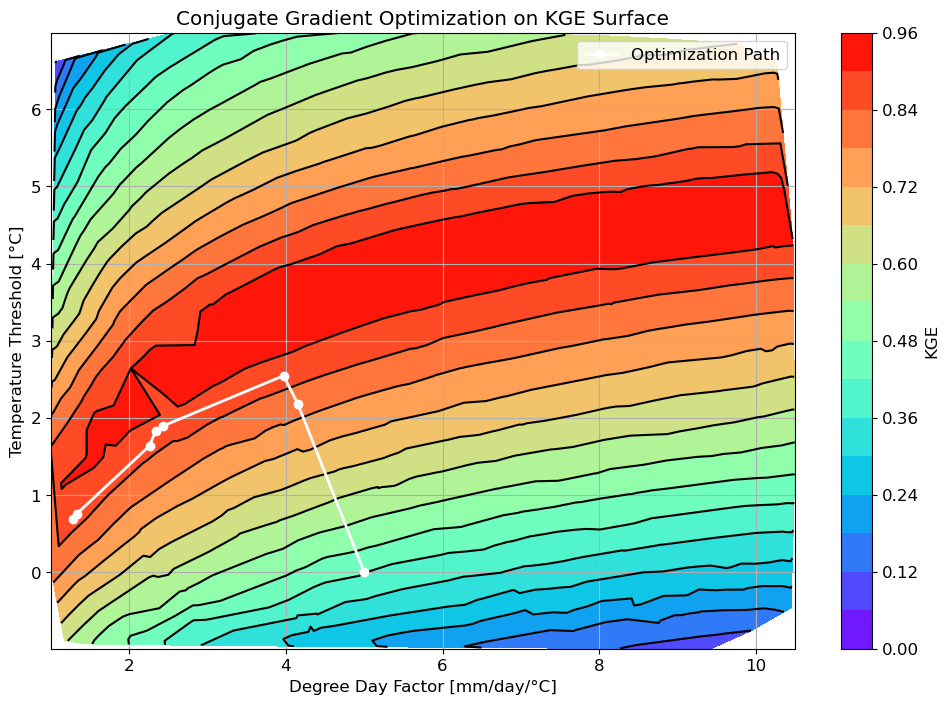

In [38]:
df_error_metric_sa = pd.read_csv(saved_error_metric_values_fname)

DD_sa = df_error_metric_sa['DD_sa'].values
Tt_sa = df_error_metric_sa['Tt_sa'].values
KGE_sa = df_error_metric_sa['KGE_sa'].values

# Create a figure for the animation
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the KGE surface
contour = ax.tricontour(DD_sa,Tt_sa,KGE_sa,levels=15,colors='k')
contourf = ax.tricontourf(DD_sa,Tt_sa,KGE_sa,levels=15,cmap='rainbow')
cbar = plt.colorbar(contourf, ax=ax)
cbar.set_label("KGE")

# Add labels
plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
ax.set_title('Conjugate Gradient Optimization on KGE Surface')

intermediate_guesses = np.vstack((initial_guess, intermediate_guesses))

# Plot the optimization path as an animation
line, = ax.plot([], [], '-o', color='white', label='Optimization Path', lw=2)
ax.legend()

# Initialize the animation
def init():
    line.set_data([], [])
    return line,

# Update function for each frame
def update(frame):
    # Plot the path up to the current frame
    line.set_data(intermediate_guesses[:frame+1, 0], intermediate_guesses[:frame+1, 1])
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(intermediate_guesses), init_func=init, blit=True, interval=500)

# Save or display the animation
ani.save('downhill_simplex_kge_optimization.gif', writer='pillow', fps=2)  # Save as GIF

![Conjugate Gradient Optimization on KGE](./downhill_simplex_kge_optimization.gif)

### Using an Alternative Objective Function

Would we get a similar or different answer if we chose a different objective function to optimize on? Let's try the same thing again, but this time using RMSE as the objective function instead of KGE.

In [39]:
def objective_function_rmse(params):
    DD_exp, Tt_exp = params
    
    # 1. Call Snow-17 model 
    SWE_m, Sm_m, Pliq_m = Snow17(Ta_exp,P_exp,DD_exp,Tt_exp)
    
    # 2. Get RMSE value for simulated SWE
    RMSE_exp = RMSE(SWE_m,SWE_o)

    # 3. Return RMSE because the optimization function we're using seeks minimization
    return RMSE_exp
    

In [40]:
intermediate_guesses_list_rmse = []

def callback(params):
    intermediate_guesses_list_rmse.append(params.copy())
    
initial_guess = [DD_i, Tt_i]

optimized_params_rmse = optimize.minimize(
    objective_function_rmse,
    initial_guess, 
    callback=callback, 
    method='CG',
    jac='3-point',
    options={
        'disp': True,
        'maxiter': 2000,
    }
    )

intermediate_guesses_rmse = np.array(intermediate_guesses_list_rmse)

print("Optimized Parameters:", optimized_params_rmse.x)

optimized_DD_rmse = optimized_params_rmse.x[0]
optimized_Tt_rmse = optimized_params_rmse.x[1]

calibrated_SWE_rmse, clibrates_Sm_rmse, calibrated_Pliq_rmse = Snow17(Ta_exp, P_exp, optimized_DD_rmse, optimized_Tt_rmse)


         Current function value: 32.601995
         Iterations: 18
         Function evaluations: 507
         Gradient evaluations: 99
Optimized Parameters: [7.66714768 4.28137641]


/Users/lejoflores/miniconda3/envs/geos505/lib/python3.11/site-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


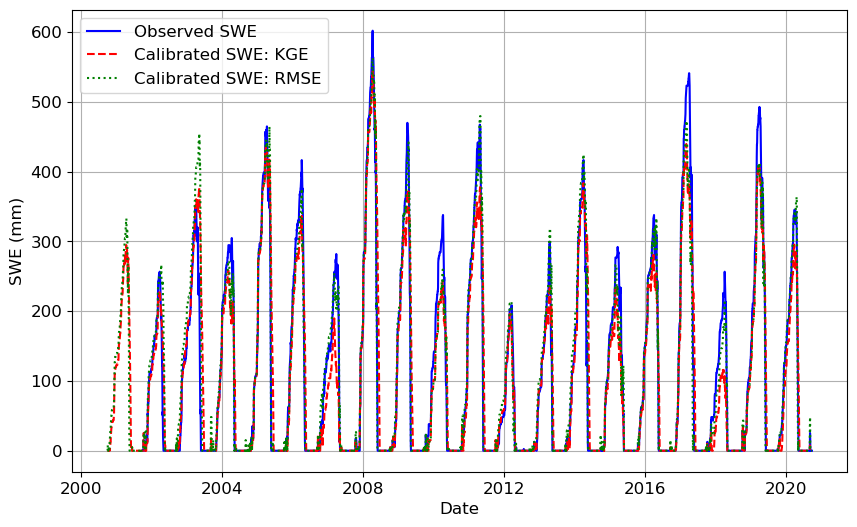

In [41]:

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 6))
plt.plot(t, SWE_o, label='Observed SWE', color='blue')
plt.plot(t, calibrated_SWE, label='Calibrated SWE: KGE', color='red', linestyle='--')
plt.plot(t, calibrated_SWE_rmse, label='Calibrated SWE: RMSE', color='green', linestyle=':')
plt.xlabel("Date")
plt.ylabel("SWE (mm)")
plt.legend()
plt.grid()
plt.show()

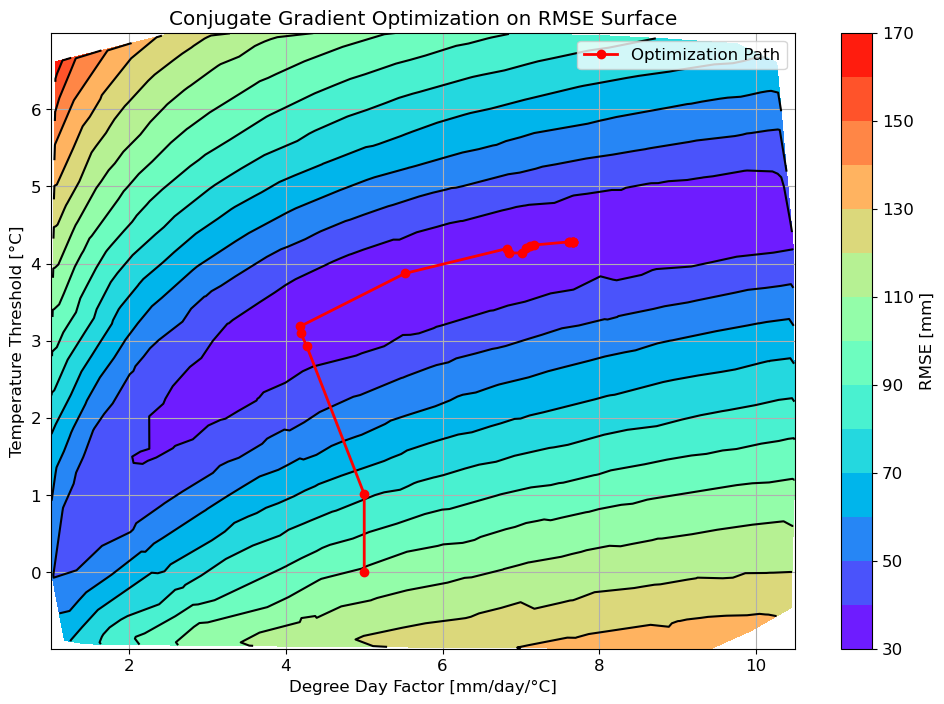

In [42]:
RMSE_sa = df_error_metric_sa['RMSE_sa'].values

# Create a figure for the animation
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the KGE surface
contour = ax.tricontour(DD_sa,Tt_sa,RMSE_sa,levels=15,colors='k')
contourf = ax.tricontourf(DD_sa,Tt_sa,RMSE_sa,levels=15,cmap='rainbow')
cbar = plt.colorbar(contourf, ax=ax)
cbar.set_label('RMSE [mm]')

# Add labels
plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
ax.set_title('Conjugate Gradient Optimization on RMSE Surface')

intermediate_guesses_rmse = np.vstack((initial_guess, intermediate_guesses_rmse))

# Plot the optimization path as an animation
line, = ax.plot([], [], '-o', color='red', label='Optimization Path', lw=2)
ax.legend()

# Initialize the animation
def init():
    line.set_data([], [])
    return line,

# Update function for each frame
def update(frame):
    # Plot the path up to the current frame
    line.set_data(intermediate_guesses_rmse[:frame+1, 0], intermediate_guesses_rmse[:frame+1, 1])
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(intermediate_guesses_rmse), init_func=init, blit=True, interval=500)

# Save or display the animation
ani.save('downhill_simplex_rmse_optimization.gif', writer='pillow', fps=2)  # Save as GIF

![Conjugate Gradient Optimization on RMSE Surface](./downhill_simplex_rmse_optimization.gif)